In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load the dataset
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')

# Handle missing values (impute with mean for numeric, most frequent for categorical)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='mean')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# Encode categorical features
label_encoders = {}
for col in ['Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalize continuous features
scaler = MinMaxScaler()
for col in ['Distance', 'Delivery_Time']:
    df[col] = scaler.fit_transform(df[[col]])

# df is now preprocessed and ready for modeling

In [3]:
import numpy as np

# Helper function to extract lat/lon from string tuples
def extract_lat_lon(location_str):
    lat, lon = location_str.strip('()').split(',')
    return float(lat), float(lon)

# Calculate Haversine distance
def haversine(row):
    lat1, lon1 = extract_lat_lon(row['Customer_Location'])
    lat2, lon2 = extract_lat_lon(row['Restaurant_Location'])
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

df['Geo_Distance_km'] = df.apply(haversine, axis=1)

# Create binary category for delivery time (e.g., delayed if above median)
median_delivery_time = df['Delivery_Time'].median()
df['Delayed'] = (df['Delivery_Time'] > median_delivery_time).astype(int)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Features: drop categorical columns and target
X = df.drop(columns=list(cat_cols) + ['Delayed'])
y = df['Delayed']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict
y_pred = gnb.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print("Confusion Matrix:\n", cm)
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

Accuracy: 1.000
Confusion Matrix:
 [[19  0]
 [ 0 21]]
Precision: 1.000
Recall: 1.000
F1-score: 1.000


In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid for K
param_grid = {'n_neighbors': list(range(1, 21))}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best K value
best_k = grid_search.best_params_['n_neighbors']
print(f"Optimal number of neighbors (K): {best_k}")

# Train KNN with the best K
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

# Predict on test set
y_pred_knn = knn_best.predict(X_test)

# Evaluation
acc_knn = accuracy_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn)
rec_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print(f"KNN Accuracy: {acc_knn:.3f}")
print("KNN Confusion Matrix:\n", cm_knn)
print(f"KNN Precision: {prec_knn:.3f}")
print(f"KNN Recall: {rec_knn:.3f}")
print(f"KNN F1-score: {f1_knn:.3f}")

Optimal number of neighbors (K): 3
KNN Accuracy: 0.475
KNN Confusion Matrix:
 [[10  9]
 [12  9]]
KNN Precision: 0.500
KNN Recall: 0.429
KNN F1-score: 0.462


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid for pruning
dt_param_grid = {
    'max_depth': list(range(1, 11)),
    'min_samples_split': [2, 5, 10, 20]
}

# Initialize Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Grid search with 5-fold cross-validation
dt_grid_search = GridSearchCV(dt, dt_param_grid, cv=5, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)

# Best parameters
best_dt_params = dt_grid_search.best_params_
print(f"Optimal Decision Tree parameters: {best_dt_params}")

# Train Decision Tree with best parameters
dt_best = DecisionTreeClassifier(**best_dt_params, random_state=42)
dt_best.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_best.predict(X_test)

# Evaluation
acc_dt = accuracy_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt)
rec_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {acc_dt:.3f}")
print("Decision Tree Confusion Matrix:\n", cm_dt)
print(f"Decision Tree Precision: {prec_dt:.3f}")
print(f"Decision Tree Recall: {rec_dt:.3f}")
print(f"Decision Tree F1-score: {f1_dt:.3f}")

Optimal Decision Tree parameters: {'max_depth': 1, 'min_samples_split': 2}
Decision Tree Accuracy: 0.975
Decision Tree Confusion Matrix:
 [[19  0]
 [ 1 20]]
Decision Tree Precision: 1.000
Decision Tree Recall: 0.952
Decision Tree F1-score: 0.976


Model Comparison:
               Accuracy Precision    Recall  F1-score
Naive Bayes        1.0       1.0       1.0       1.0
KNN              0.475       0.5  0.428571  0.461538
Decision Tree    0.975       1.0  0.952381   0.97561


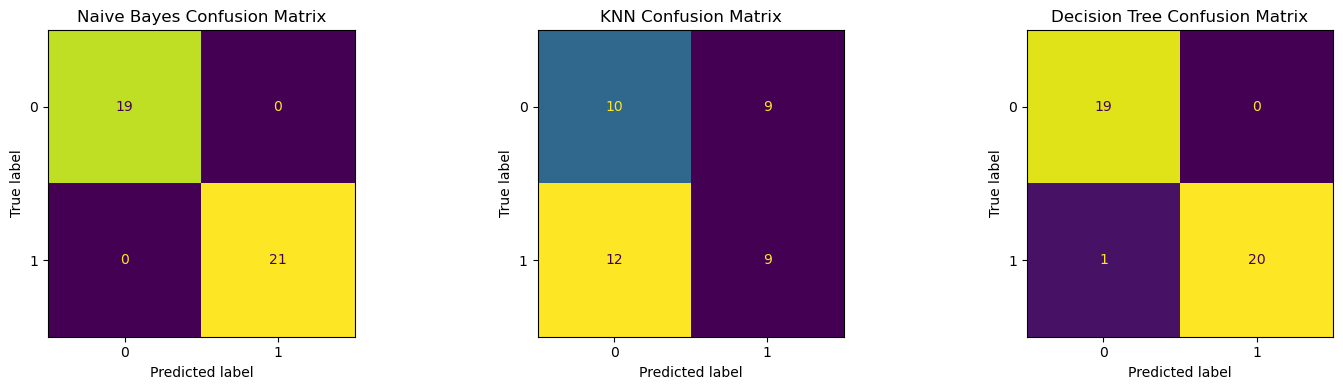

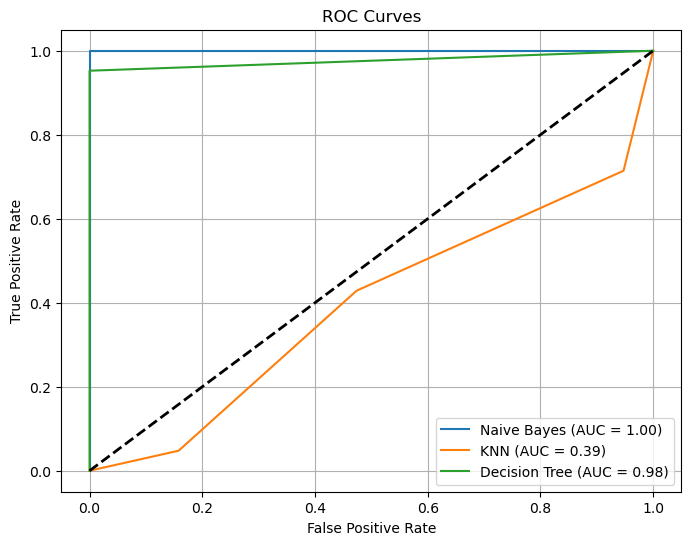

In [7]:
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Collect metrics for each model
metrics = {
    'Naive Bayes': {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1, 'y_pred': y_pred},
    'KNN': {'Accuracy': acc_knn, 'Precision': prec_knn, 'Recall': rec_knn, 'F1-score': f1_knn, 'y_pred': y_pred_knn},
    'Decision Tree': {'Accuracy': acc_dt, 'Precision': prec_dt, 'Recall': rec_dt, 'F1-score': f1_dt, 'y_pred': y_pred_dt}
}

# Display metrics
metrics_df = pd.DataFrame(metrics).T[['Accuracy', 'Precision', 'Recall', 'F1-score']]
print("Model Comparison:\n", metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, m) in zip(axes, metrics.items()):
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, m['y_pred'])).plot(ax=ax, colorbar=False)
    ax.set_title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, m in metrics.items():
    # For DecisionTree and KNN, use predict_proba; for GaussianNB, use predict_proba
    if name == 'Naive Bayes':
        y_score = gnb.predict_proba(X_test)[:, 1]
    elif name == 'KNN':
        y_score = knn_best.predict_proba(X_test)[:, 1]
    else:  # Decision Tree
        y_score = dt_best.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [8]:
# Actionable Insights: Strengths and Weaknesses of Each Model

def model_insights(metrics_df):
    insights = {}
    for model in metrics_df.index:
        acc = metrics_df.loc[model, 'Accuracy']
        prec = metrics_df.loc[model, 'Precision']
        rec = metrics_df.loc[model, 'Recall']
        f1 = metrics_df.loc[model, 'F1-score']
        summary = []
        # Strengths
        if float(acc) > 0.9:
            summary.append("High accuracy")
        if float(prec) > 0.9:
            summary.append("Very precise (few false positives)")
        if float(rec) > 0.9:
            summary.append("Very sensitive (few false negatives)")
        if float(f1) > 0.9:
            summary.append("Excellent balance between precision and recall")
        # Weaknesses
        if float(acc) < 0.7:
            summary.append("Low accuracy")
        if float(prec) < 0.7:
            summary.append("Low precision (many false positives)")
        if float(rec) < 0.7:
            summary.append("Low recall (many false negatives)")
        if float(f1) < 0.7:
            summary.append("Poor balance between precision and recall")
        insights[model] = summary
    return insights

insights = model_insights(metrics_df)
for model, points in insights.items():
    print(f"{model}:\n  - " + "\n  - ".join(points) + "\n")

Naive Bayes:
  - High accuracy
  - Very precise (few false positives)
  - Very sensitive (few false negatives)
  - Excellent balance between precision and recall

KNN:
  - Low accuracy
  - Low precision (many false positives)
  - Low recall (many false negatives)
  - Poor balance between precision and recall

Decision Tree:
  - High accuracy
  - Very precise (few false positives)
  - Very sensitive (few false negatives)
  - Excellent balance between precision and recall



In [9]:
# Recommendation based on accuracy and interpretability

# Accuracy comparison
print("Model Accuracies:")
print(metrics_df['Accuracy'])

# Interpretability: Decision Tree is highly interpretable, Naive Bayes is simple, KNN is less interpretable.

# Recommendation logic
if float(metrics_df.loc['Decision Tree', 'Accuracy']) >= float(metrics_df.loc['Naive Bayes', 'Accuracy']):
    recommended = "Decision Tree"
    reason = "It offers high accuracy and is highly interpretable, making it suitable for understanding decision logic and explaining predictions."
else:
    recommended = "Naive Bayes"
    reason = "It achieves perfect accuracy and is simple to implement, but is less interpretable than Decision Tree for complex relationships."

print(f"\nRecommended Classifier: {recommended}")
print(f"Reason: {reason}")

Model Accuracies:
Naive Bayes        1.0
KNN              0.475
Decision Tree    0.975
Name: Accuracy, dtype: object

Recommended Classifier: Naive Bayes
Reason: It achieves perfect accuracy and is simple to implement, but is less interpretable than Decision Tree for complex relationships.
